# **Assessing the Impact of Central Bank Speeches on Stock Prices Using LSTM and Sentiment Analysis**

## **Introduction**

This project investigates the influence of **Central Bank speeches** (available on the [BIS website](https://www.bis.org/cbspeeches)) on stock prices by leveraging machine learning techniques. Specifically, we use a **Long Short-Term Memory (LSTM)** model, which is well-suited for capturing long-term trends in stock prices, as its core predictive engine. Additionally, sentiment analysis is incorporated to quantify the psychological impact of these speeches on financial markets.

To ensure a comprehensive analysis, the predictions were conducted on the **most heavily weighted companies within each sector of the S&P 500 index**. This approach provides insights into sector-specific influences and highlights the broader market implications of Central Bank speeches.

---

## **Motivation**

Central Banks play a pivotal role in shaping market expectations and trends through their communications. The tone and sentiment of their speeches can impact investor behavior and, consequently, stock prices. This project aims to understand and quantify this impact using an LSTM model enhanced with sentiment analysis techniques, offering a more comprehensive view than relying solely on price trends.

---

## **Objectives**

1. Evaluate the degree to which **Central Bank speeches** influence stock prices.
2. Compare the performance of models that whether incorporate or not sentiment data analysis, using the **R² (Coefficient of Determination)** as the primary evaluation metric
---

## **Methodology**

### **1. Project Structure**
The project is structured around three main axes, corresponding to the types of sentiment analysis used:
1. **FinBERT**: Sentiment analysis using a pre-trained transformer model tailored for financial text.
2. **Loughran-McDonald Dictionary (skfin)**: A rule-based sentiment analysis method for financial content.
3. **Without Sentiment Analysis**: A baseline model relying solely on stock price data.

For each model, we train them following this pipeline that will be details later:
- **Data Preprocessing**: This part includes loading the data, performing or not sentiment analysis on each text from the `news` dataset. Then, we split the data into a validation set and a training set based on dates. We keep 80% of the data for training and 20% for validation. The third step consists in performing data augmentation by "sequencing" the data. Finally, we fit a `MinMaxScaler` on the training data for each features
- **Model Training**: Training LSTM models with the same architectures on the corresponding feature set.
- **Model Evaluation**: Evaluating the model’s performance against its objectives, based on plots and on the value of the R².

Sentiment analysis, when used, is integrated into the preprocessing pipeline for its respective axis.

### **2. Data Collection**
1. **Speeches**:
   - Extracted from the [BIS Central Bank speeches database](https://www.bis.org/cbspeeches) using a Python script built with **Playwright**.
   - Speech content was preprocessed to extract relevant text and aligned with stock price data by date.

2. **Stock Prices**:
   - Historical stock prices (e.g., closing prices and trading volume) were fetched using the **yfinance** API.
   - The dataset focuses on **top S&P 500 companies** by sector weight, providing a broad market view.

3. **Target Companies**:
   - The analysis emphasizes sector-specific insights by selecting the most impactful companies in the S&P 500.


### **3. Sentiment Analysis**
Sentiment analysis is performed within the respective preprocessing pipelines for FinBERT and skfin-based approaches:
- **FinBERT**: Extracted sentiment scores (`positive`, `negative`, `neutral`) for each speech, processed with a transformer model fine-tuned for financial sentiment.
- **Loughran-McDonald Dictionary (skfin)**: Applied rule-based sentiment scoring using a dictionary of sentiment-related terms, aggregating results to align with stock price movements.

Sentiment scores, when used, are integrated into the feature set for training the LSTM model.

### **4. LSTM Model Implementation**
An **LSTM model class** was implemented for stock price prediction. Its architecture includes:
- **Inputs**: 
  - Stock price features (e.g., closing prices, trading volume).
  - Sentiment scores (from FinBERT or skfin) for axes using sentiment analysis.
- **Hidden Layers**: Stacked LSTM layers for sequential learning and fully connected layers for regression.
- **Output**: Predicted stock prices.

The training process includes:
- Batch training using **PyTorch DataLoaders**.
- Optimization with **Adam optimizer**.
- A **learning rate scheduler** for dynamic adjustment.
- **Early stopping** to mitigate overfitting by monitoring validation loss.

### **5. Comparison Models**
The methodology for each axis (FinBERT, skfin, and baseline) comprises:

1. **Data Preprocessing**:
   - Data alignment:
     - Speech dates aligned with stock prices.
     - Sentiment scores aggregated by date where applicable.
   - Scaling features using **MinMaxScaler** for consistent input magnitudes.
   - Constructing input sequences for the LSTM model with a fixed sequence length.

2. **Model Training**:
   - Trained the LSTM model using the respective features:
     - FinBERT sentiment scores combined with stock prices.
     - skfin sentiment scores combined with stock prices.
     - Stock prices only for the baseline.
   - **Mean Squared Error (MSE)** served as the loss function.

3. **Evaluation**:
   - Models were evaluated on unseen test data.
   - Key metrics:
     - **R² (Coefficient of Determination)** to assess explanatory power.
     - **Mean Squared Error (MSE)** to measure prediction error.
   - Visualizations compared predicted stock prices against actual values for qualitative insights.

### **6. Key Observations**
- Sentiment analysis approaches (FinBERT and skfin) provided incremental improvements in certain scenarios, especially for sectors sensitive to speech content.
- The baseline model performed well for companies where stock price movements are largely independent of external sentiment.
- The sequential modeling capabilities of LSTM were critical for capturing temporal dependencies in both price movements and sentiment dynamics.

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from torch.optim.lr_scheduler import OneCycleLR
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# From skfin
from sklearn.feature_extraction.text import CountVectorizer

c:\Users\mcgpr\anaconda3\envs\skfin\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Utils

Here are some functions and classes that we'll use many times through the code to compare the different results obtained. They all contain a short description for clarity.

## Functions

In [54]:
def load_data(include_news=False):
    """
    Loads financial price data and optionally economic news data.
    """
    prices = pd.read_csv('data/sp500_prices.csv')
    prices['date'] = pd.to_datetime(prices['Date'])
    prices = prices.drop(columns=['Date'])
    prices.sort_values(by='date', ascending=True, inplace=True)

    if include_news:
        news = pd.read_csv('data/bis_press_releases.csv')
        news = news.dropna()
        news['date'] = pd.to_datetime(news['date'], format='%d %b %Y')
        news.sort_values(by='date', ascending=True, inplace=True)
        return prices, news
    else:
        return prices

In [55]:
def sequencing(df, companies, sequence_length, include_news=False):
    """
    Prepares sequenced data for time series analysis with optional sentiment features.
    """
    data = []
    for company in companies:
        if include_news:
            if 'neutral' in df.columns:
                company_data = df[df['Company'] == company][['Close', 'negative', 'neutral', 'positive']].values
            else:
                company_data = df[df['Company'] == company][['Close', 'negative', 'positive']].values
            for i in range(company_data.shape[0]):
                sentiment_values = company_data[i, 1:]
                max_index = np.argmax(sentiment_values)
                binary_sentiment = np.zeros_like(sentiment_values)
                binary_sentiment[max_index] = 1
                company_data[i, 1:] = binary_sentiment
            data.append(company_data)
        else:
            company_data = df[df['Company'] == company][['Close']].values
            data.append(company_data)
    sequenced_data = []
    for d in data:
        if d.shape[0] <= sequence_length:
            print(d.shape)
            continue
        for k in range(d.shape[0] - sequence_length):
            sequence = d[k:k + sequence_length, :]
            sequenced_data.append(sequence)
    sequenced_data = np.array(sequenced_data)
    return sequenced_data

In [56]:
def evaluate_model(model, data_loader, criterion, scalers):
    """
    Evaluates the performance of a trained model on a validation dataset.
    """
    model.eval()
    predictions = []
    targets = []
    test_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            test_loss += loss.item()

            preds = outputs.squeeze().cpu().numpy()
            true_values = y_batch.cpu().numpy()
            predictions.extend(preds)
            targets.extend(true_values)
    # Reshape to 2D arrays (scaler expects 2D inputs)
    predictions = np.array(predictions).reshape(-1, 1)
    targets = np.array(targets).reshape(-1, 1)

    scaler = scalers[0]
    # Apply inverse transform
    predictions = scaler.inverse_transform(predictions)
    targets = scaler.inverse_transform(targets)
    return predictions.flatten(), targets.flatten(), test_loss/len(data_loader)

## Classes

In [57]:
class TimeSeriesDataset(Dataset):
    """
    Custom PyTorch Dataset for time series data.
    """
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx, :-1, :]
        y = self.data[idx, -1, 0]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [58]:
class LSTM(nn.Module):
    """
    Custom LSTM model for time series prediction.
    """
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, intermediate_dim=64, seed=42):
        super(LSTM, self).__init__()
        self.linear = nn.Linear(input_dim, intermediate_dim)
        self.sigmoid = nn.Sigmoid()
        self.initial_linear = nn.Linear(intermediate_dim, intermediate_dim)
        self.lstm = nn.LSTM(intermediate_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.seed = seed
        self.init_weights()
    
    def forward(self, x):
        # Pass through the initial linear layer
        x = self.linear(x)
        x = self.sigmoid(x)
        x = self.initial_linear(x)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out
    
    def init_weights(self):
        torch.manual_seed(self.seed)
        nn.init.xavier_uniform_(self.linear.weight.data)
        nn.init.constant_(self.linear.bias.data, 0)
        # Initialize weights for the initial linear layer
        nn.init.xavier_uniform_(self.initial_linear.weight.data)
        nn.init.constant_(self.initial_linear.bias.data, 0)

        # Initialize weights for the LSTM layer
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)

        # Initialize weights for the fully connected layer
        nn.init.xavier_uniform_(self.fc.weight.data)
        nn.init.constant_(self.fc.bias.data, 0)

In [59]:
class EarlyStopping:
    """
    Custom Early Stopping class.
    """
    def __init__(self, patience=10, verbose=True, min_delta=1e-4, save_path="best_model.pth"):
        self.patience = patience
        self.verbose = verbose
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.save_path = save_path

    def __call__(self, val_loss, model):
            if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
                # New best loss found, save the model
                self.best_loss = val_loss
                self.counter = 0
                torch.save(model.state_dict(), self.save_path)
                if self.verbose:
                    print(f"Validation loss improved. Model saved to {self.save_path}")
            else:
                # No improvement, increment counter
                self.counter += 1
                if self.verbose:
                    print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
                if self.counter >= self.patience:
                    self.early_stop = True
                    print("Early stopping triggered.")

# Feeding Price without sentiment as inputs

## Preprocessing

### Data processing

In [9]:
companies = [
    'Amazon', 'Apple Inc.', 'Meta Platforms', 'UnitedHealth Group', 
    'Procter & Gamble', 'Honeywell', 'ExxonMobil', 'NextEra Energy', 
    'American Tower', 'JPMorgan Chase'
]

In [10]:
prices = load_data()

In [11]:
dates = prices['date'].drop_duplicates().values
split_date = dates[int(0.8 * len(dates))]

train = prices[prices['date'] <= split_date]
val = prices[prices['date'] > split_date]
num_val_dates = len(val['date'].drop_duplicates().values)

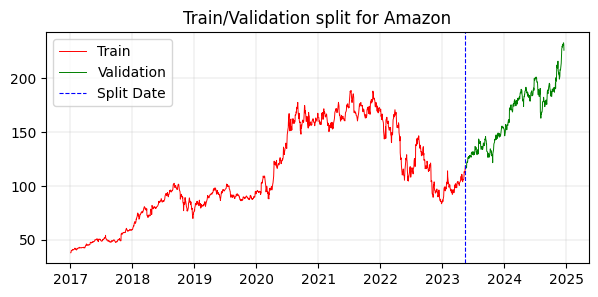

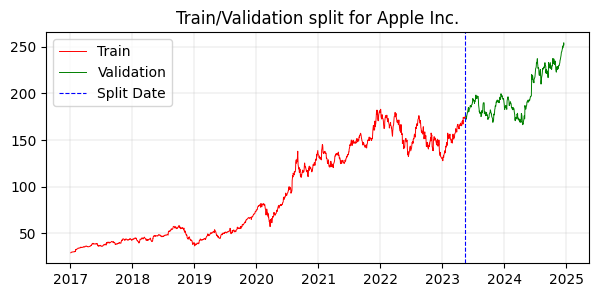

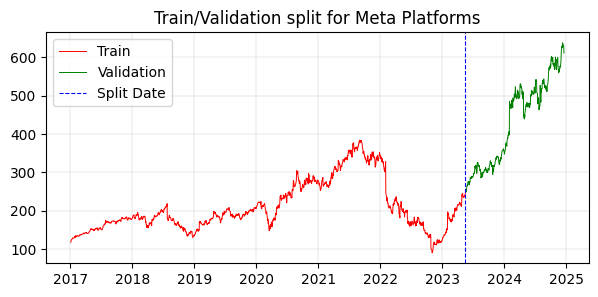

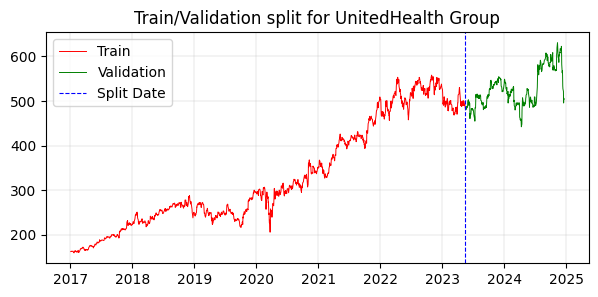

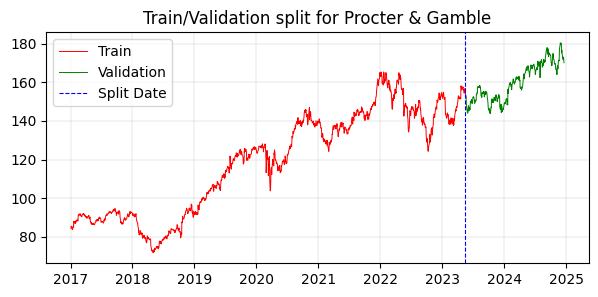

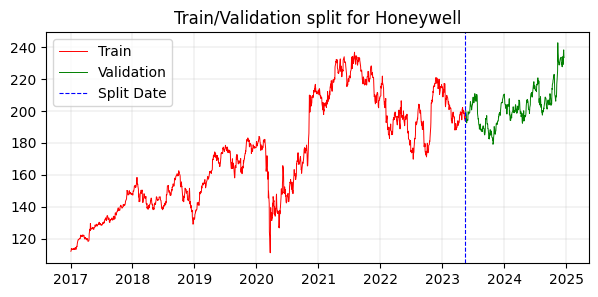

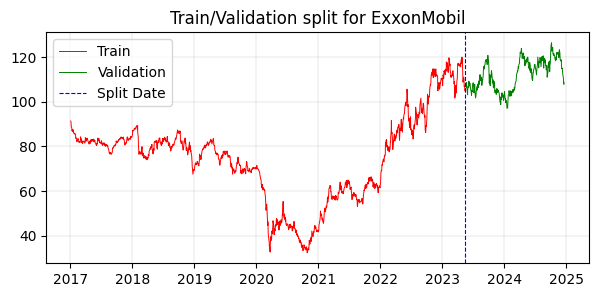

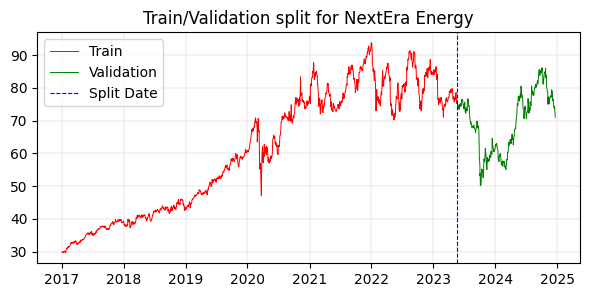

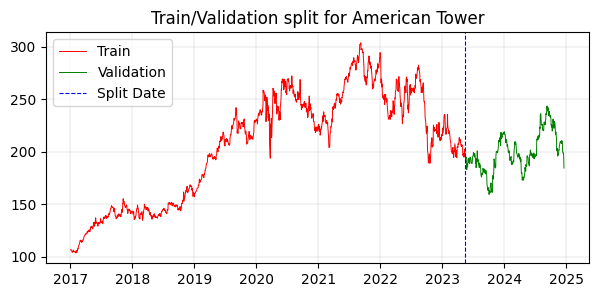

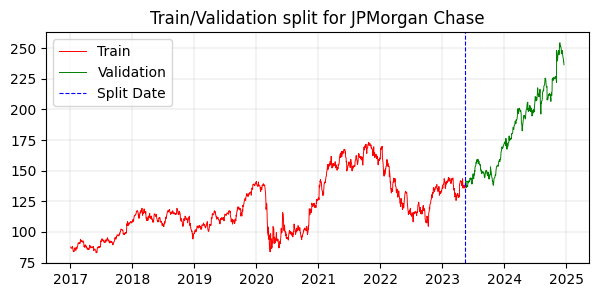

In [12]:
for company in companies:
    train_ex = train[train['Company'] == company]['High'].values
    train_dates = train['date'].drop_duplicates().values
    val_ex = val[val['Company'] == company]['High'].values
    val_dates = val['date'].drop_duplicates().values

    plt.figure(figsize=(7, 3))
    plt.grid(linewidth=0.2)
    plt.plot(train_dates, train_ex, linewidth=0.7, label='Train', c='r')
    plt.plot(val_dates, val_ex, linewidth=0.7, label='Validation', c='g')
    plt.axvline(x=split_date, color='b', linestyle='--', linewidth=0.8, label='Split Date')
    plt.legend()
    plt.title(f'Train/Validation split for {company}')
plt.show()

### Data Augmentation

In [13]:
train_sequence = sequencing(train, companies, 70)
val_sequence = sequencing(val, companies, 50)

print(f'sequenced train data: {train_sequence.shape}')
print(f'sequenced validation data: {val_sequence.shape}')

sequenced train data: (15350, 70, 1)
sequenced validation data: (3500, 50, 1)


## Training

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data, test_data = train_test_split(train_sequence, test_size=0.2, random_state=42, shuffle=True)
train_data = np.array(train_data)
test_data = np.array(test_data)

num_features = train_data.shape[2]  # Number of features
scalers = [MinMaxScaler(feature_range=(0, 1)) for _ in range(num_features)]

train_data_scaled = np.zeros_like(train_data)
test_data_scaled = np.zeros_like(test_data)

for feature_idx in range(num_features):
    train_feature = train_data[:, :, feature_idx].reshape(-1, 1)  # Shape: (num_samples * seq_len, 1)
    test_feature = test_data[:, :, feature_idx].reshape(-1, 1)
    
    scalers[feature_idx].fit(train_feature)
    
    train_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(train_feature).reshape(train_data.shape[0], -1)
    test_data_scaled[:, :, feature_idx] = scalers[feature_idx>].transform(test_feature).reshape(test_data.shape[0], -1)

train_data = train_data_scaled
test_data = test_data_scaled

train_dataset = TimeSeriesDataset(train_data)
test_dataset = TimeSeriesDataset(test_data)

generator = torch.Generator()
generator.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, generator=generator)

In [15]:
input_dim = train_data.shape[2]
hidden_dim = 512
num_layers = 1
output_dim = 1

learning_rate=  0.0005
dropout = 0.1
weight_decay = 5e-5

num_epochs = 256

model = LSTM(
    input_dim, 
    hidden_dim, 
    num_layers, 
    output_dim
).to(device)

early_stopping = EarlyStopping(
    patience=32,
    save_path='best_model/withoutsentiment.pth'
)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay
)
steps_per_epoch = len(train_loader)  # Total number of batches in one epoch

scheduler = OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch
)

train_loss_rec = []
test_loss_rec = []

print('Model defined, start training ...')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
    
    # Testing loop
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            test_outputs = model(x_test)
            loss = criterion(test_outputs.squeeze(), y_test)
            test_loss += loss.item()
    
    # Print metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.8f}, "
          f"Test Loss: {test_loss/len(test_loader):.8f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    train_loss_rec.append(train_loss/len(train_loader))
    test_loss_rec.append(test_loss/len(test_loader))
    
    early_stopping(test_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

Model defined, start training ...
Epoch [1/256], Train Loss: 0.03449297, Test Loss: 0.03031158, LR: 0.000020
Validation loss improved. Model saved to best_model/withoutsentiment.pth
Epoch [2/256], Train Loss: 0.02733842, Test Loss: 0.02511863, LR: 0.000021
Validation loss improved. Model saved to best_model/withoutsentiment.pth
Epoch [3/256], Train Loss: 0.01165797, Test Loss: 0.00031530, LR: 0.000022
Validation loss improved. Model saved to best_model/withoutsentiment.pth
Epoch [4/256], Train Loss: 0.00029698, Test Loss: 0.00025795, LR: 0.000023
Validation loss improved. Model saved to best_model/withoutsentiment.pth
Epoch [5/256], Train Loss: 0.00029666, Test Loss: 0.00030672, LR: 0.000025
EarlyStopping counter: 1 out of 32
Epoch [6/256], Train Loss: 0.00026856, Test Loss: 0.00024579, LR: 0.000027
Validation loss improved. Model saved to best_model/withoutsentiment.pth
Epoch [7/256], Train Loss: 0.00027415, Test Loss: 0.00055055, LR: 0.000030
EarlyStopping counter: 1 out of 32
Epoch 

## Result

### Train/Test Loss through epochs

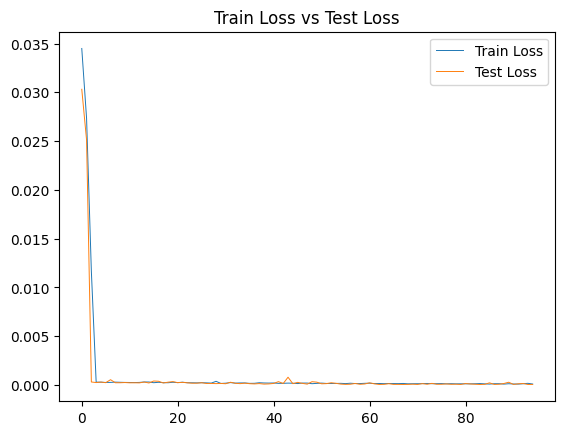

In [16]:
plt.plot(train_loss_rec, linewidth=0.7, label='Train Loss')
plt.plot(test_loss_rec, linewidth=0.7, label='Test Loss')
plt.legend()
plt.title('Train Loss vs Test Loss')
plt.show()

### Reload model

In [17]:
model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
model.load_state_dict(torch.load('best_model/withoutsentiment.pth'))

C:\Users\mcgpr\AppData\Local\Temp/ipykernel_15812/689271088.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model/withoutsentiment

<All keys matched successfully>

### Test Set

In [18]:
predictions, targets, loss = evaluate_model(model, test_loader, criterion, scalers)
print(f'Loss on test set: {loss:.8f}')
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Test Set: {r2:.4f}")

Loss on test set: 0.00006269
R² Coefficient on Test Set: 0.9981


### Validation Set

In [19]:
val_data_scaled = np.zeros_like(val_sequence)
for feature_idx in range(num_features):
    feature = val_sequence[:, :, feature_idx].reshape(-1, 1)  # Shape: (num_samples * seq_len, 1)
        
    val_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(feature).reshape(val_sequence.shape[0], -1)

val_data = val_data_scaled
val_dataset = TimeSeriesDataset(val_data)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

R² Coefficient on Validation Set: 0.998129


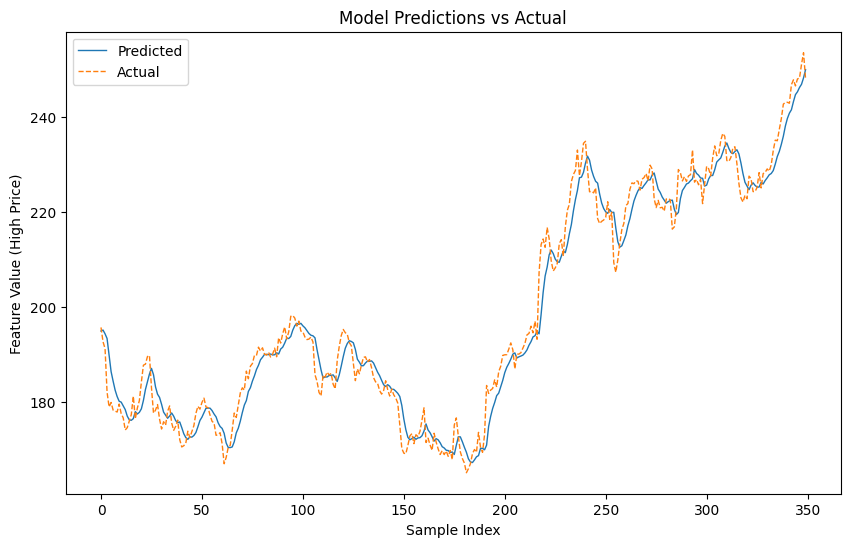

In [ ]:
predictions, targets, loss = evaluate_model(model, val_loader, criterion, scalers)
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Validation Set: {r2:.6f}")

for k in range(len(companies))
    window = 350
    initial = 350*k
    plt.figure(figsize=(7, 3))
    plt.plot(predictions[initial: initial+window], label="Predicted", linestyle="-", linewidth=1)
    plt.plot(targets[initial: initial+window], label="Actual", linestyle="--", linewidth=1)
    plt.title("Model Predictions vs Actual")
    plt.xlabel("Sample Index")
    plt.ylabel("Feature Value (High Price)")
    plt.legend()
plt.show()

# Feeding Single Company + FinBERT sentiments

## Preprocessing

### Processing Data

In [21]:
prices, news = load_data(include_news=True)

In [22]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# Move the model to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Get class labels
class_labels = model.config.id2label
prob_labels = model.config.label2id

# Example input text
text1 = news['content'].values[0]

inputs = tokenizer(text1, return_tensors="pt", truncation=True, padding=True)
inputs = {key: value.to(device) for key, value in inputs.items()}

# Perform inference
with torch.no_grad():  # No gradient calculation needed for predictions
    outputs = model(**inputs)

# Compute probabilities and predicted class
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
predicted_class = torch.argmax(probs, dim=-1).item()

# Print the results
print("Predicted class:", class_labels[predicted_class])
print("Probabilities:", probs.cpu())  # Move probabilities back to CPU for printing
print('Labels assignation:', prob_labels)

Predicted class: neutral
Probabilities: tensor([[0.1068, 0.2003, 0.6929]])
Labels assignation: {'positive': 0, 'negative': 1, 'neutral': 2}


In [23]:
def sentiment_labelling(df):
    """
    Perform sentiment labelling on the given DataFrame.
    Adds 'negative', 'neutral', and 'positive' columns to the DataFrame.
    Processes the DataFrame to group by date and fill missing values.
    """
    model.to(device)

    df['negative'] = 0.0
    df['neutral'] = 0.0
    df['positive'] = 0.0

    # Initialize the tqdm progress bar
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing Sentiment Analysis", dynamic_ncols=True):
        text = row['content']
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to CUDA
        with torch.no_grad():
            outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze().tolist()
        df.at[index, 'positive'] = probs[0]
        df.at[index, 'negative'] = probs[1]
        df.at[index, 'neutral'] = probs[2]

    # Drop unnecessary columns
    if {'url', 'title', 'content'}.issubset(df.columns):
        df = df.drop(columns=['url', 'title', 'content'])

    # Group by date and calculate mean sentiment scores
    df = df.groupby("date").mean().reset_index()

    # Ensure the 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Create a full date range
    date_range = pd.date_range(start=df["date"].min(), end=df["date"].max())

    # Reindex to include all dates and forward-fill missing values
    df = df.set_index("date").reindex(date_range)
    df = df.fillna(method="ffill").reset_index()
    df.rename(columns={"index": "date"}, inplace=True)

    df = df.sort_values(by="date", ascending=True).reset_index(drop=True)

    return df

In [24]:
news = sentiment_labelling(news)

Processing Sentiment Analysis: 100%|██████████| 6886/6886 [02:42<00:00, 42.33it/s]


In [25]:
news.head()

,date,negative,neutral,positive
0,2017-01-24,0.200346,0.692896,0.106758
1,2017-01-25,0.027849,0.678937,0.293214
2,2017-01-26,0.057628,0.740360,0.202012
3,2017-01-27,0.685202,0.247965,0.066833
4,2017-01-28,0.685202,0.247965,0.066833


In [26]:
merged = pd.merge(prices, news, on='date', how='inner')
dates = merged['date'].drop_duplicates().values
split_date = dates[int(0.8 * len(dates))]

train = merged[merged['date'] <= split_date]
val = merged[merged['date'] > split_date]
num_val_dates = len(val['date'].drop_duplicates().values)

In [27]:
merged.head()

,Open,High,Low,Close,Volume,Company,date,negative,neutral,positive
0,13.960000,14.340000,13.950000,14.240000,16160200,Regions Financial Corporation,2017-01-24,0.200346,0.692896,0.106758
1,1678.000000,1719.479980,1678.000000,1700.000000,45200,"NVR, Inc.",2017-01-24,0.200346,0.692896,0.106758
2,39.623909,40.496979,39.469444,40.449966,1372858,Pentair,2017-01-24,0.200346,0.692896,0.106758
3,84.970001,86.580002,84.959999,86.400002,737800,Wabtec,2017-01-24,0.200346,0.692896,0.106758
4,167.160004,169.750000,167.160004,169.509995,600800,Domino's,2017-01-24,0.200346,0.692896,0.106758


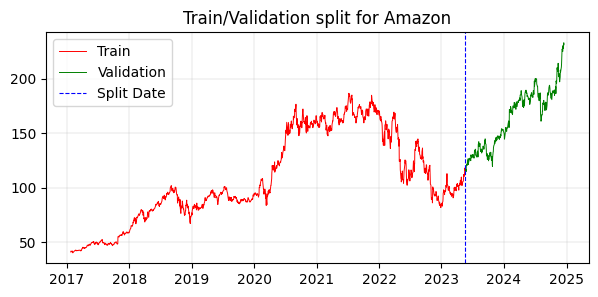

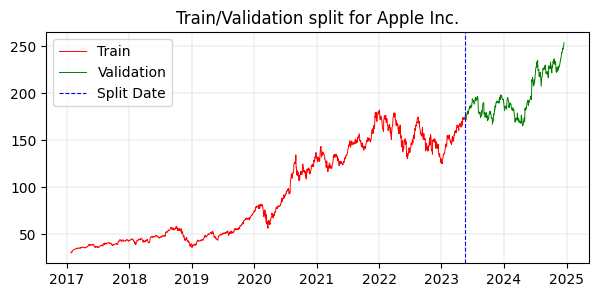

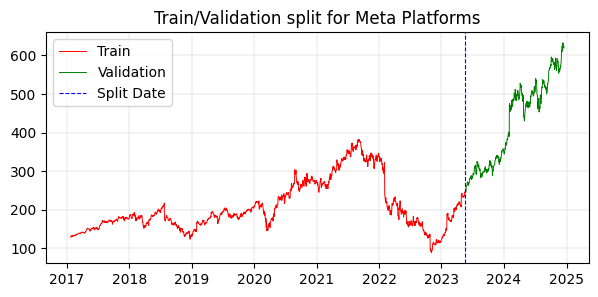

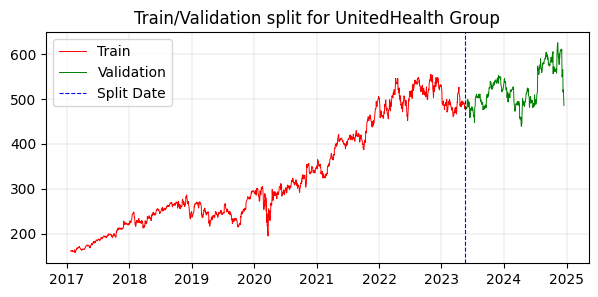

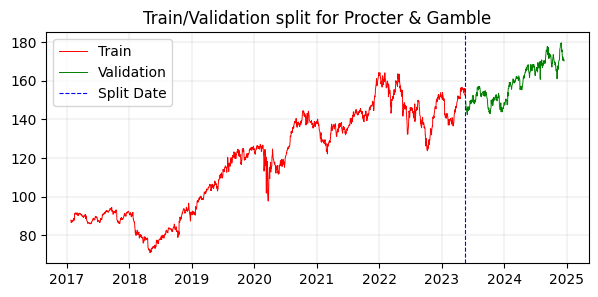

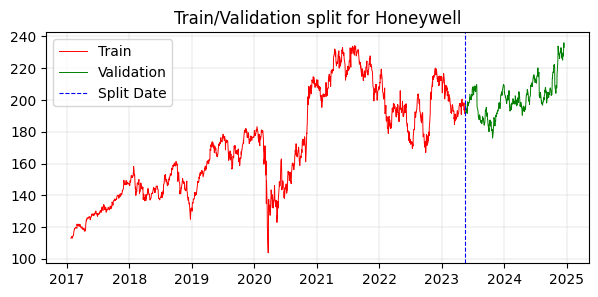

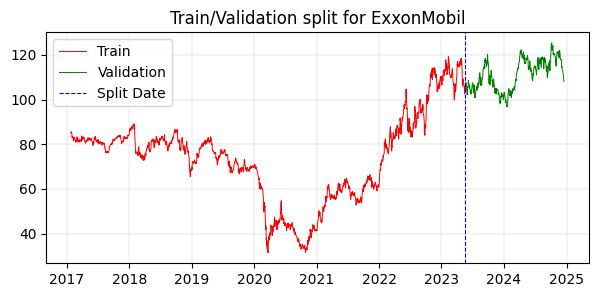

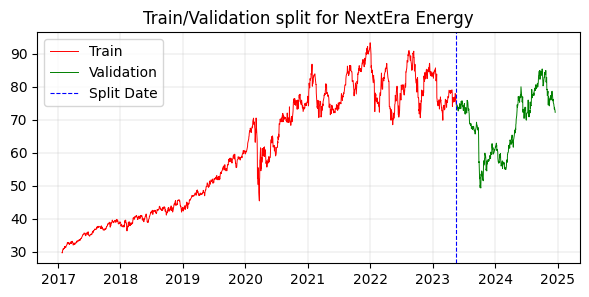

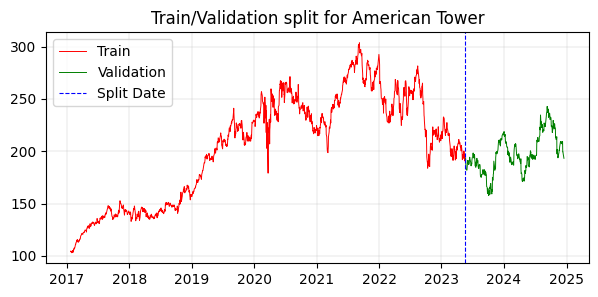

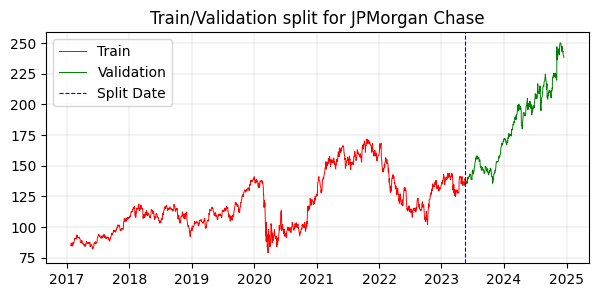

In [28]:
for company in companies:
    train_ex = train[train['Company'] == company]['Close'].values
    train_dates = train['date'].drop_duplicates().values
    val_ex = val[val['Company'] == company]['Close'].values
    val_dates = val['date'].drop_duplicates().values

    plt.figure(figsize=(7, 3))
    plt.grid(linewidth=0.2)
    plt.plot(train_dates, train_ex, linewidth=0.7, label='Train', c='r')
    plt.plot(val_dates, val_ex, linewidth=0.7, label='Validation', c='g')
    plt.axvline(x=split_date, color='b', linestyle='--', linewidth=0.8, label='Split Date')
    plt.legend()
    plt.title(f'Train/Validation split for {company}')
plt.show()

### Data Augmentation

In [29]:
train_sequence = sequencing(train, companies, 70, include_news=True)
val_sequence = sequencing(val, companies, 50, include_news=True)

print(f'sequenced train data: {train_sequence.shape}')
print(f'sequenced validation data: {val_sequence.shape}')

sequenced train data: (15220, 70, 4)
sequenced validation data: (3470, 50, 4)


## Training

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data, test_data = train_test_split(train_sequence, test_size=0.2, random_state=42, shuffle=True)
train_data = np.array(train_data)
test_data = np.array(test_data)

num_features = train_data.shape[2]  # Number of features
scalers = [MinMaxScaler(feature_range=(0, 1)) for _ in range(num_features)]

train_data_scaled = np.zeros_like(train_data)
test_data_scaled = np.zeros_like(test_data)

for feature_idx in range(num_features):
    train_feature = train_data[:, :, feature_idx].reshape(-1, 1)  # Shape: (num_samples * seq_len, 1)
    test_feature = test_data[:, :, feature_idx].reshape(-1, 1)
    
    scalers[feature_idx].fit(train_feature)
    
    train_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(train_feature).reshape(train_data.shape[0], -1)
    test_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(test_feature).reshape(test_data.shape[0], -1)

train_data = train_data_scaled
test_data = test_data_scaled

train_dataset = TimeSeriesDataset(train_data)
test_dataset = TimeSeriesDataset(test_data)

generator = torch.Generator()
generator.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, generator=generator)

In [31]:
input_dim = train_data.shape[2]
hidden_dim = 512
num_layers = 1
output_dim = 1

learning_rate=  0.0005
dropout = 0.1
weight_decay = 5e-5

num_epochs = 256

model = LSTM(
    input_dim, 
    hidden_dim, 
    num_layers, 
    output_dim
).to(device)

early_stopping = EarlyStopping(
    patience=32,
    save_path='best_model/FinBert.pth'
)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay
)
steps_per_epoch = len(train_loader)  # Total number of batches in one epoch

scheduler = OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch
)

train_loss_rec = []
test_loss_rec = []

print('Model defined, start training ...')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
    
    # Testing loop
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            test_outputs = model(x_test)
            loss = criterion(test_outputs.squeeze(), y_test)
            test_loss += loss.item()
    
    # Print metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.8f}, "
          f"Test Loss: {test_loss/len(test_loader):.8f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    train_loss_rec.append(train_loss/len(train_loader))
    test_loss_rec.append(test_loss/len(test_loader))
    
    early_stopping(test_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

Model defined, start training ...
Epoch [1/256], Train Loss: 0.03204404, Test Loss: 0.02771045, LR: 0.000020
Validation loss improved. Model saved to best_model/FinBert.pth
Epoch [2/256], Train Loss: 0.02505376, Test Loss: 0.01601671, LR: 0.000021
Validation loss improved. Model saved to best_model/FinBert.pth
Epoch [3/256], Train Loss: 0.00366960, Test Loss: 0.00077537, LR: 0.000022
Validation loss improved. Model saved to best_model/FinBert.pth
Epoch [4/256], Train Loss: 0.00050366, Test Loss: 0.00033093, LR: 0.000023
Validation loss improved. Model saved to best_model/FinBert.pth
Epoch [5/256], Train Loss: 0.00030120, Test Loss: 0.00026463, LR: 0.000025
Validation loss improved. Model saved to best_model/FinBert.pth
Epoch [6/256], Train Loss: 0.00028344, Test Loss: 0.00024619, LR: 0.000027
Validation loss improved. Model saved to best_model/FinBert.pth
Epoch [7/256], Train Loss: 0.00030365, Test Loss: 0.00023575, LR: 0.000030
Validation loss improved. Model saved to best_model/FinBe

## Result

### Train/Test loss through epochs

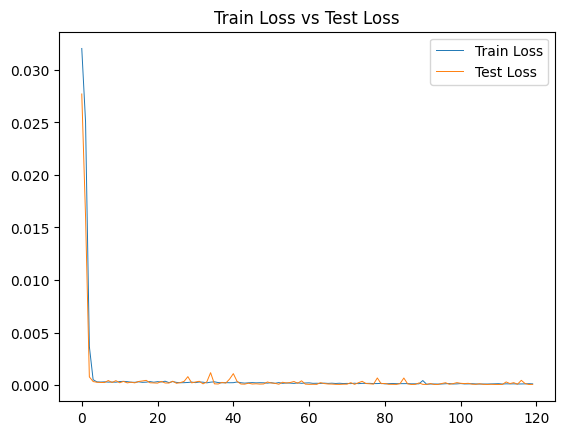

In [32]:
plt.plot(train_loss_rec, linewidth=0.7, label='Train Loss')
plt.plot(test_loss_rec, linewidth=0.7, label='Test Loss')
plt.legend()
plt.title('Train Loss vs Test Loss')
plt.show()

### Reload Model

In [33]:
model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
model.load_state_dict(torch.load('best_model/FinBert.pth'))

C:\Users\mcgpr\AppData\Local\Temp/ipykernel_15812/2839631630.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model/FinBert.pth'))


<All keys matched successfully>

### Test Set

In [34]:
predictions, targets, loss = evaluate_model(model, test_loader, criterion, scalers)
print(f'Loss on test set: {loss:.8f}')
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Test Set: {r2:.4f}")

Loss on test set: 0.00005380
R² Coefficient on Test Set: 0.9982


### Validation Set

In [35]:
val_data_scaled = np.zeros_like(val_sequence)
for feature_idx in range(num_features):
    feature = val_sequence[:, :, feature_idx].reshape(-1, 1)  # Shape: (num_samples * seq_len, 1)
        
    val_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(feature).reshape(val_sequence.shape[0], -1)

val_data = val_data_scaled
val_dataset = TimeSeriesDataset(val_data)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Loss on val set: 0.00012307
R² Coefficient on Validation Set: 0.998327


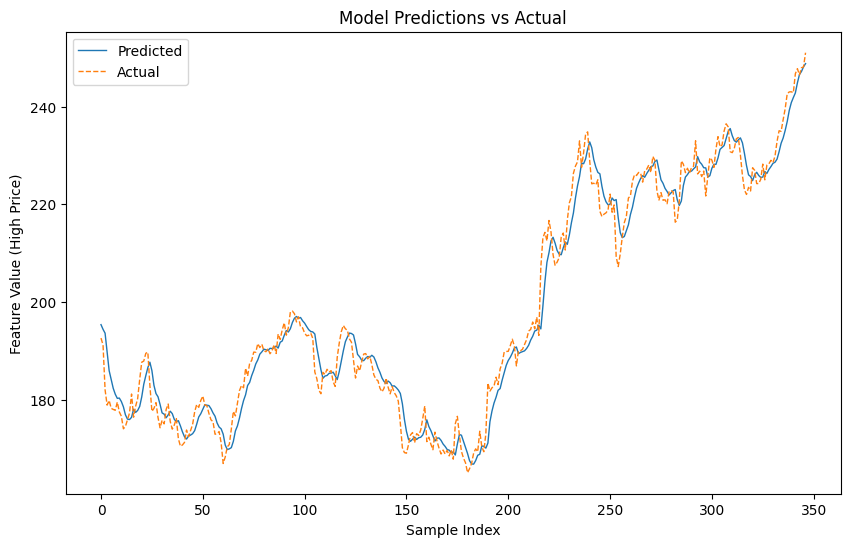

In [36]:
predictions, targets, loss = evaluate_model(model, val_loader, criterion, scalers)
print(f'Loss on val set: {loss:.8f}')
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Validation Set: {r2:.6f}")

window = 347
initial = 347
plt.figure(figsize=(10, 6))
plt.plot(predictions[initial: initial+window], label="Predicted", linestyle="-", linewidth=1)
plt.plot(targets[initial: initial+window], label="Actual", linestyle="--", linewidth=1)
plt.title("Model Predictions vs Actual")
plt.xlabel("Sample Index")
plt.ylabel("Feature Value (High Price)")
plt.legend()
plt.show()

# Feeding Single Company + sentiments

## Preprocessing

### Data Processing

In [37]:
prices, news = load_data(include_news=True)

In [38]:
from datasets import load_loughran_mcdonald_dictionary

In [39]:
lm = load_loughran_mcdonald_dictionary()

INFO:datasets:Loading from cache file: data\Loughran-McDonald_MasterDictionary_1993-2023.csv


In [40]:
def sentiment_labelling(df, lm, column):
    """
    Perform sentiment labelling on the given DataFrame.
    Adds 'negative', 'neutral', and 'positive' columns to the DataFrame.
    Processes the DataFrame to group by date and fill missing values.
    """
    # Initialize sentiment columns
    # Extract the text column
    X = df[column]
    
    # Define sentiment functions
    funcs = {
        "negative": lambda x: x.Negative > 0,
        "positive": lambda x: x.Positive > 0,
        "all": lambda x: x.Word.notna(),
    }

    # Helper function to compute total count for a specific sentiment
    def get_total_count(X, lm, func):
        m = CountVectorizer(vocabulary=lm.loc[func].Word.str.lower().values)
        return pd.DataFrame(m.fit_transform(X).toarray(), index=X.index).sum(axis=1)

    # Compute sentiment counts for each sentiment category
    lm_counts = pd.concat({k: get_total_count(X, lm, v) for k, v in funcs.items()}, axis=1)

    sentiment_columns = ["negative", "positive"]
    lm_counts[sentiment_columns] = lm_counts[sentiment_columns].div(lm_counts[sentiment_columns].sum(axis=1), axis=0)

    lm_counts.drop(columns=["all"], inplace=True)

    if 'date' in df.columns:
        lm_counts['date'] = df['date'].values

    lm_counts.reset_index(drop=True, inplace=True)

    if {'url', 'title', 'content'}.issubset(df.columns):
        df = df.drop(columns=['url', 'title', 'content'])

    lm_counts = lm_counts.groupby("date").mean().reset_index()

    lm_counts['date'] = pd.to_datetime(lm_counts['date'])

    date_range = pd.date_range(start=lm_counts["date"].min(), end=lm_counts["date"].max())

    lm_counts = lm_counts.set_index("date").reindex(date_range)
    lm_counts = lm_counts.fillna(method="ffill").reset_index()
    lm_counts.rename(columns={"index": "date"}, inplace=True)

    lm_counts = lm_counts.sort_values(by="date", ascending=True).reset_index(drop=True)

    return lm_counts

In [41]:
news = sentiment_labelling(news, lm, 'content')

In [42]:
news.head()

,date,negative,positive
0,2017-01-24,0.563636,0.436364
1,2017-01-25,0.448746,0.551254
2,2017-01-26,0.482812,0.517188
3,2017-01-27,0.730769,0.269231
4,2017-01-28,0.730769,0.269231


In [43]:
merged = pd.merge(prices, news, on='date', how='inner')
dates = merged['date'].drop_duplicates().values
split_date = dates[int(0.8 * len(dates))]

train = merged[merged['date'] <= split_date]
val = merged[merged['date'] > split_date]
num_val_dates = len(val['date'].drop_duplicates().values)

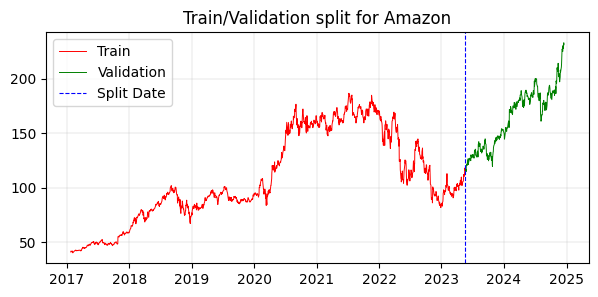

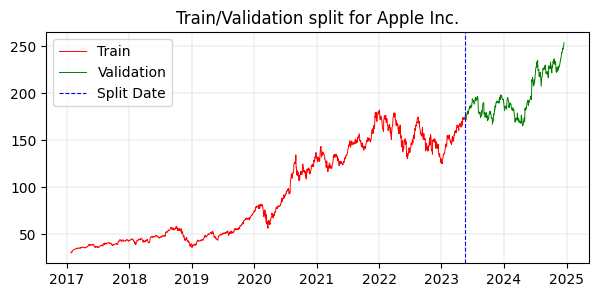

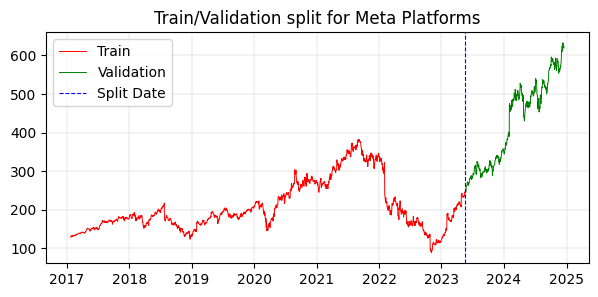

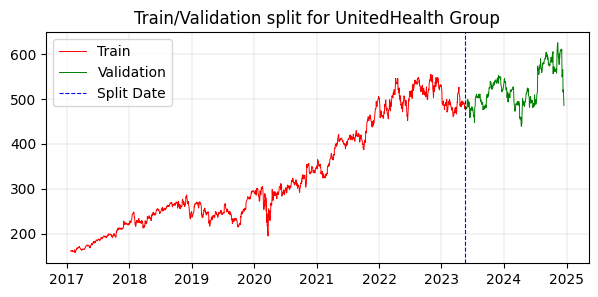

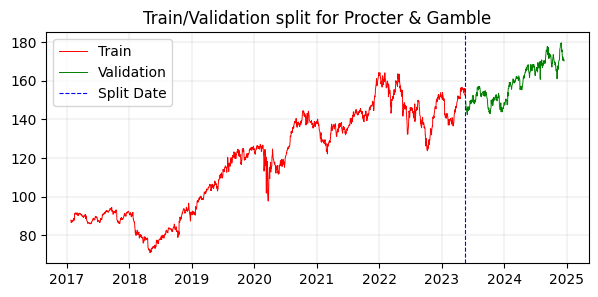

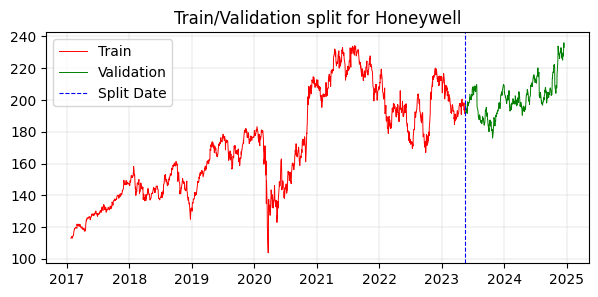

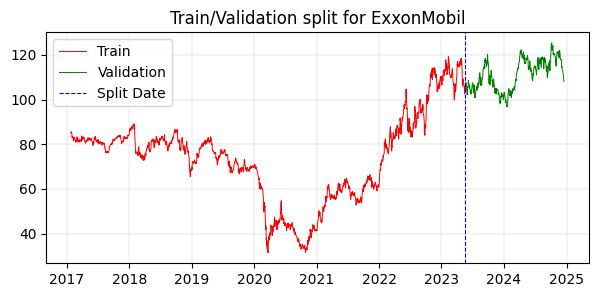

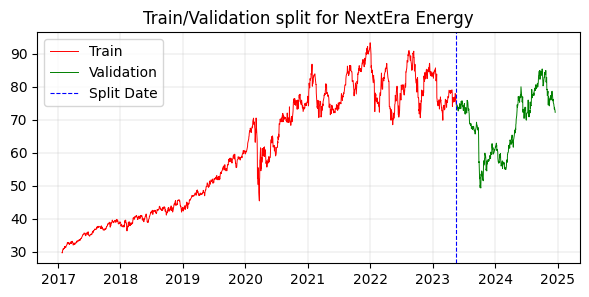

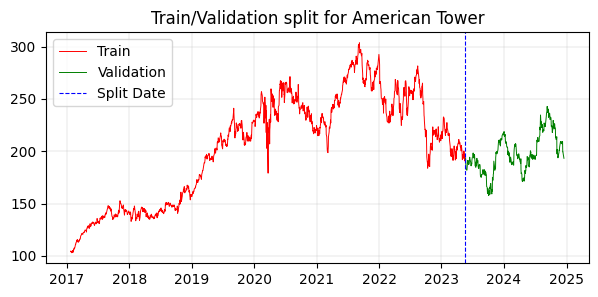

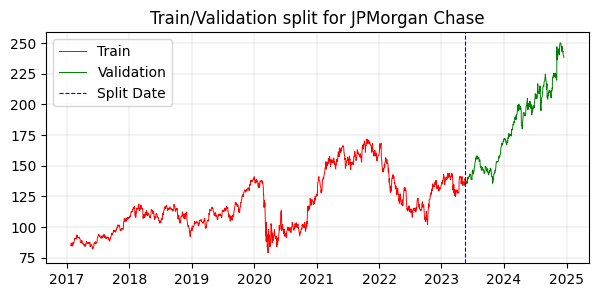

In [44]:
for company in companies:
    train_ex = train[train['Company'] == company]['Close'].values
    train_dates = train['date'].drop_duplicates().values
    val_ex = val[val['Company'] == company]['Close'].values
    val_dates = val['date'].drop_duplicates().values

    plt.figure(figsize=(7, 3))
    plt.grid(linewidth=0.2)
    plt.plot(train_dates, train_ex, linewidth=0.7, label='Train', c='r')
    plt.plot(val_dates, val_ex, linewidth=0.7, label='Validation', c='g')
    plt.axvline(x=split_date, color='b', linestyle='--', linewidth=0.8, label='Split Date')
    plt.legend()
    plt.title(f'Train/Validation split for {company}')
plt.show()

In [45]:
merged.head()

,Open,High,Low,Close,Volume,Company,date,negative,positive
0,13.960000,14.340000,13.950000,14.240000,16160200,Regions Financial Corporation,2017-01-24,0.563636,0.436364
1,1678.000000,1719.479980,1678.000000,1700.000000,45200,"NVR, Inc.",2017-01-24,0.563636,0.436364
2,39.623909,40.496979,39.469444,40.449966,1372858,Pentair,2017-01-24,0.563636,0.436364
3,84.970001,86.580002,84.959999,86.400002,737800,Wabtec,2017-01-24,0.563636,0.436364
4,167.160004,169.750000,167.160004,169.509995,600800,Domino's,2017-01-24,0.563636,0.436364


### Data Augmentation

In [46]:
train_sequence = sequencing(train, companies, 70, include_news=True)
val_sequence = sequencing(val, companies, 50, include_news=True)

print(f'sequenced train data: {train_sequence.shape}')
print(f'sequenced validation data: {val_sequence.shape}')

sequenced train data: (15220, 70, 3)
sequenced validation data: (3470, 50, 3)


## Training

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data, test_data = train_test_split(train_sequence, test_size=0.2, random_state=42, shuffle=True)
train_data = np.array(train_data)
test_data = np.array(test_data)

num_features = train_data.shape[2]  # Number of features
scalers = [MinMaxScaler(feature_range=(0, 1)) for _ in range(num_features)]

train_data_scaled = np.zeros_like(train_data)
test_data_scaled = np.zeros_like(test_data)

for feature_idx in range(num_features):
    train_feature = train_data[:, :, feature_idx].reshape(-1, 1)  # Shape: (num_samples * seq_len, 1)
    test_feature = test_data[:, :, feature_idx].reshape(-1, 1)
    
    scalers[feature_idx].fit(train_feature)
    
    train_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(train_feature).reshape(train_data.shape[0], -1)
    test_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(test_feature).reshape(test_data.shape[0], -1)

train_data = train_data_scaled
test_data = test_data_scaled

train_dataset = TimeSeriesDataset(train_data)
test_dataset = TimeSeriesDataset(test_data)

generator = torch.Generator()
generator.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, generator=generator)

In [48]:
input_dim = train_data.shape[2]
hidden_dim = 512
num_layers = 1
output_dim = 1

learning_rate=  0.0005
dropout = 0.1
weight_decay = 5e-5

num_epochs = 256

model = LSTM(
    input_dim, 
    hidden_dim, 
    num_layers, 
    output_dim
).to(device)

early_stopping = EarlyStopping(
    patience=32,
    save_path='best_model/lough_macdo.pth'
)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay
)
steps_per_epoch = len(train_loader)  # Total number of batches in one epoch

scheduler = OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch
)

train_loss_rec = []
test_loss_rec = []

print('Model defined, start training ...')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
    
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            test_outputs = model(x_test)
            loss = criterion(test_outputs.squeeze(), y_test)
            test_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.8f}, "
          f"Test Loss: {test_loss/len(test_loader):.8f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    train_loss_rec.append(train_loss/len(train_loader))
    test_loss_rec.append(test_loss/len(test_loader))
    
    early_stopping(test_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

Model defined, start training ...
Epoch [1/256], Train Loss: 0.03720128, Test Loss: 0.02968454, LR: 0.000020
Validation loss improved. Model saved to best_model/lough_macdo.pth
Epoch [2/256], Train Loss: 0.02990951, Test Loss: 0.02711919, LR: 0.000021
Validation loss improved. Model saved to best_model/lough_macdo.pth
Epoch [3/256], Train Loss: 0.02378592, Test Loss: 0.00906700, LR: 0.000022
Validation loss improved. Model saved to best_model/lough_macdo.pth
Epoch [4/256], Train Loss: 0.00145635, Test Loss: 0.00038368, LR: 0.000023
Validation loss improved. Model saved to best_model/lough_macdo.pth
Epoch [5/256], Train Loss: 0.00035850, Test Loss: 0.00033019, LR: 0.000025
Validation loss improved. Model saved to best_model/lough_macdo.pth
Epoch [6/256], Train Loss: 0.00032150, Test Loss: 0.00029323, LR: 0.000027
Validation loss improved. Model saved to best_model/lough_macdo.pth
Epoch [7/256], Train Loss: 0.00033826, Test Loss: 0.00033086, LR: 0.000030
EarlyStopping counter: 1 out of 3

## Result

### Train/Test Loss through epochs

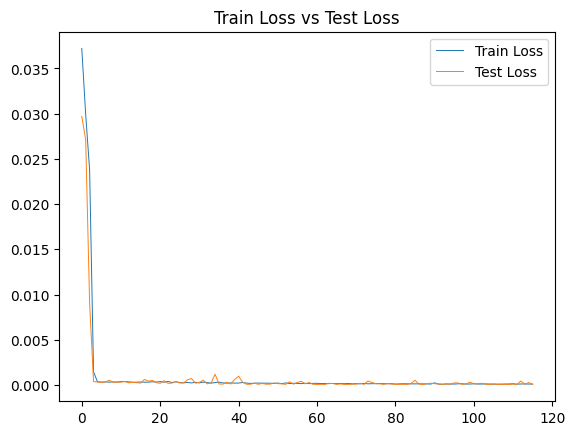

In [49]:
plt.plot(train_loss_rec, linewidth=0.7, label='Train Loss')
plt.plot(test_loss_rec, linewidth=0.7, label='Test Loss')
plt.legend()
plt.title('Train Loss vs Test Loss')
plt.show()

### Reload

In [50]:
model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
model.load_state_dict(torch.load('best_model/lough_macdo.pth'))

C:\Users\mcgpr\AppData\Local\Temp/ipykernel_15812/2950336300.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model/lough_macdo.pth

<All keys matched successfully>

### Test Set

In [51]:
predictions, targets, loss = evaluate_model(model, test_loader, criterion, scalers)
print(f'Loss on test set: {loss:.8f}')
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Test Set: {r2:.4f}")

Loss on test set: 0.00005960
R² Coefficient on Test Set: 0.9981


### Validation Set

In [52]:
val_data_scaled = np.zeros_like(val_sequence)
for feature_idx in range(num_features):
    feature = val_sequence[:, :, feature_idx].reshape(-1, 1)  # Shape: (num_samples * seq_len, 1)
        
    val_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(feature).reshape(val_sequence.shape[0], -1)

val_data = val_data_scaled
val_dataset = TimeSeriesDataset(val_data)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Loss on val set: 0.00014242
R² Coefficient on Validation Set: 0.998060


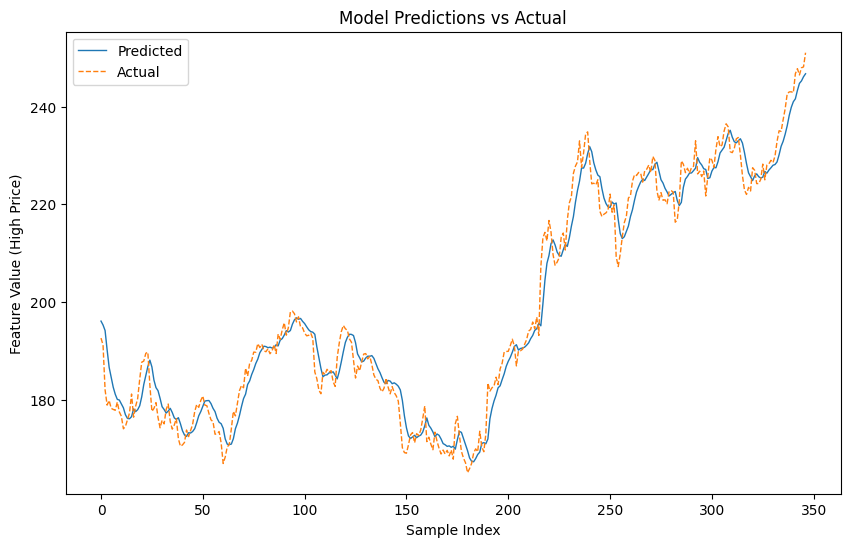

In [53]:
predictions, targets, loss = evaluate_model(model, val_loader, criterion, scalers)
print(f'Loss on val set: {loss:.8f}')
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Validation Set: {r2:.6f}")

window = 347
initial = 347
plt.figure(figsize=(10, 6))
plt.plot(predictions[initial: initial+window], label="Predicted", linestyle="-", linewidth=1)
plt.plot(targets[initial: initial+window], label="Actual", linestyle="--", linewidth=1)
plt.title("Model Predictions vs Actual")
plt.xlabel("Sample Index")
plt.ylabel("Feature Value (High Price)")
plt.legend()
plt.show()